In [1]:
import sys
sys.path.append("../")
import numpy as np
from scipy.fftpack import fftfreq
import os
import glob
import cv2
import csv
from utils import show_peak, VarianceFilter, FFTStrip,FFTSpaceStrip, doubleplot, doFilterFFT,tripleplot, VelocityStrip, watershed_image_hough,DiffVelocityStrip
import pandas as pd
from tifffile import imread, imwrite
from scipy.fftpack import fft
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, binary_erosion

from scipy.signal import find_peaks
from skimage import data, io

from skimage.filters import threshold_otsu, threshold_mean
from skimage.filters import roberts, sobel, scharr, prewitt, gaussian
try:
    from pathlib import Path
    Path().expanduser()
except (ImportError, AttributeError):
        from pathlib2 import Path

try:
        import tempfile
        tempfile.TemporaryDirectory
except (ImportError, AttributeError):
       from backports import tempfile

In [2]:
Kymo = '/home/sancere/Downloads/DistanceMethodCurvature_Dpachys_controlTrackID1.tif'
Embryo = '/home/sancere/Downloads/Dpachys_control.tif'
Csv = '/home/sancere/Downloads/Co-ordinatesETrack_Dpachys_controlCellID01.txt'
savedir = '/home/sancere/Downloads/'
Time_unit = 10
Xcalibration = 0.034
#Block size for averaged measurments
blocksize = 50
timeav = 30
# Skip the display points on the clock
displayskip = 2
#ignore the last few blocks 
ignorelast = 1
Path(savedir).mkdir(exist_ok = True)


In [3]:

AverageVelocity = []
Block = []
AverageFrequ = []
Frequency = []
ImageName = []
AnteriorList = []
PosteriorList = []

 
    
Kymoimage = imread(Kymo)
Embryoimage = imread(Embryo)
x, y, t, distance, perimeter, N, M = np.loadtxt(Csv, skiprows = 3, unpack=True)
Blockiter = int(len(x)/max(t))
print('Total Perimeter points on Kymo:', Blockiter)
Dictionary = []
for i in range(0, Blockiter):
    Dictionary.append([i, x[i], y[i]])



   



Total Perimeter points on Kymo: 2401


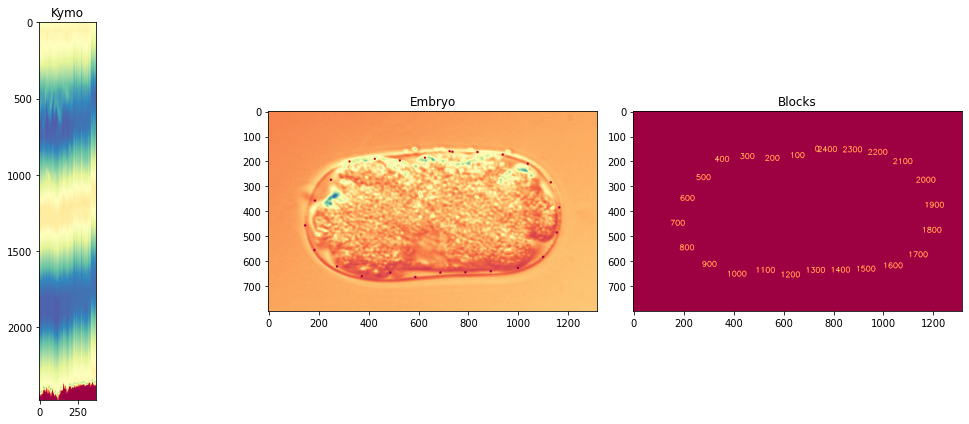

In [4]:
# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
# org 
org = (50, 50) 
# fontScale 
fontScale = 1
 
color = (255, 255, 0) 
thickness = 1
Clock = np.zeros([Embryoimage.shape[1], Embryoimage.shape[2]])
for i in range(0, Blockiter, 2 *blocksize):
    cv2.circle(Embryoimage[0,:], (int(x[i]), int(y[i])), 5,(255,0,0), thickness = -1 )
    cv2.putText(Clock, str(i), (int(x[i]), int(y[i])), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
tripleplot(Kymoimage,Embryoimage[0,:], Clock, 'Kymo', 'Embryo', 'Blocks')

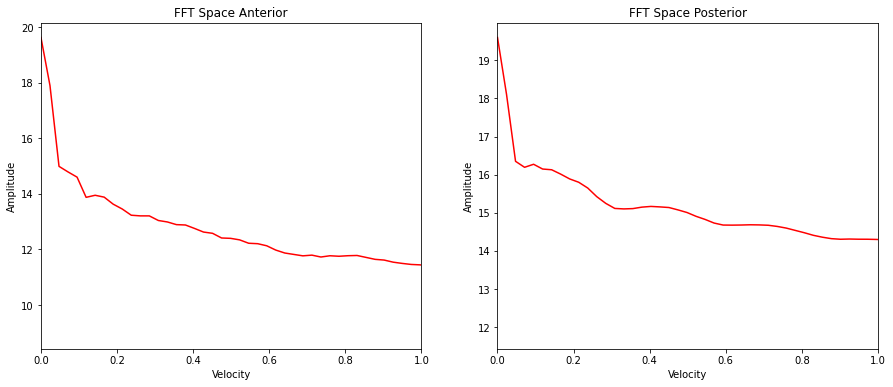

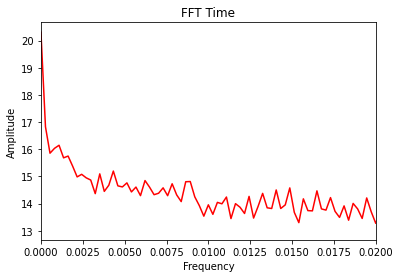

/home/sancere/anaconda3/envs/tensorflowGPU/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/home/sancere/anaconda3/envs/tensorflowGPU/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


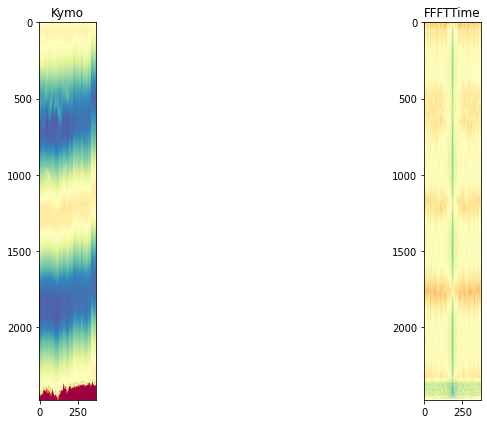

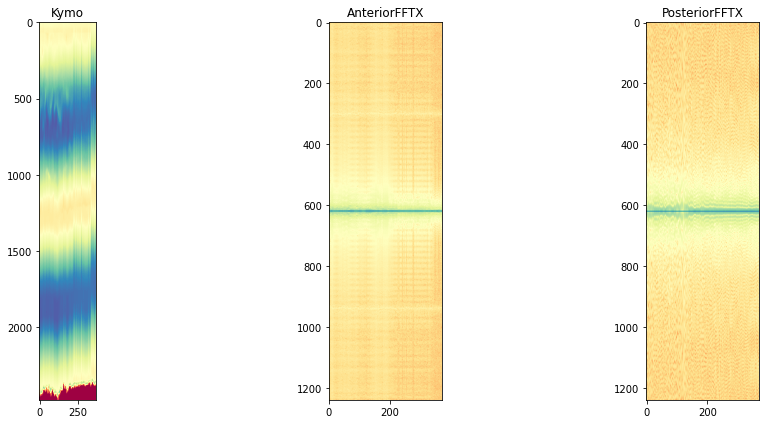

In [12]:
Name = os.path.basename(os.path.splitext(Kymo)[0])

#Get simple velocity 

#Anterior Part
FFTSpaceImageHalf, AddedVA, velocityA = FFTSpaceStrip(Kymoimage[0:Kymoimage.shape[0]//2,:], Xcalibration)

#Posterior Part
FFTSpaceImageSecHalf, AddedVP, velocityP = FFTSpaceStrip(Kymoimage[Kymoimage.shape[0]//2:,:], Xcalibration)

df = pd.DataFrame(list(zip(velocityA,AddedVA)),columns =['Velocity Anterior', 'Amplitude'])
df.to_csv(Name + 'Velocity Anterior' +  '.csv', index = False)  

df = pd.DataFrame(list(zip(velocityP,AddedVP)),columns =['Velocity Posterior', 'Amplitude'])
df.to_csv(Name + 'Velocity Posterior' +  '.csv', index = False)  

FFTTimeImage, AddedT, frequ = FFTStrip(Kymoimage, Time_unit)
df = pd.DataFrame(list(zip(frequ,AddedT)),columns =['Frequency', 'Amplitude'])
df.to_csv(Name + 'Frequency' +  '.csv', index = False)  

imwrite((savedir + Name + 'FFTSpaceAnterior' + '.tif' ) , np.log(FFTSpaceImageHalf.astype('float32')))
imwrite((savedir + Name + 'FFTSpacePosterior' + '.tif' ) , np.log(FFTSpaceImageSecHalf.astype('float32')))
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()
ax[0].plot( velocityA,np.log(AddedVA), 'r')
ax[0].set_xlabel('Velocity')
ax[0].set_ylabel('Amplitude')
ax[0].set_xlim([0,1])
ax[0].set_title('FFT Space Anterior')

ax[1].plot( velocityP,np.log(AddedVP), 'r')
ax[1].set_xlabel('Velocity')
ax[1].set_ylabel('Amplitude')
ax[1].set_xlim([0,1])
ax[1].set_title('FFT Space Posterior')
plt.show()
plt.plot( frequ,np.log(AddedT), 'r')
plt.title('FFT Time')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim([0,0.02])
plt.show()


imwrite((savedir + Name + 'FFTTime' + '.tif' ) , np.log(FFTTimeImage.astype('float32')))

doubleplot(Kymoimage, np.log(FFTTimeImage), 'Kymo', 'FFFTTime')
tripleplot(Kymoimage,np.log(FFTSpaceImageHalf), np.log(FFTSpaceImageSecHalf), 'Kymo', 'AnteriorFFTX', 'PosteriorFFTX')